In [1]:
import horton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
from scipy.interpolate import CubicSpline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def read_input():
    lines = open('results').readlines()
    results = []
    coordinates = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        if parts[0] == '#R':
            q = parts[1].strip('/').split('/')
            row['target'] = q[-2]
            if row['target'] == 'NN-2':
                row['target'] = 'N2-2'
            row['box'] = int(q[-1].split('-')[-1])
            row['energies'] = np.array([float(_) for _ in parts[2:]])
            row['numatoms'] = len(row['energies'])
            results.append(row)
        if parts[0] == '#C':
            numatoms = int(parts[1])
            row['numatoms'] = numatoms
            row['zs'] = [int(float(_)) for _ in parts[2:2+numatoms]]
            row['coords'] = np.array([float(_) for _ in parts[-3*numatoms:]]).reshape(-1, 3)
            coordinates.append(row)
    return pd.DataFrame(results), pd.DataFrame(coordinates)
r, c = read_input()
def read_energies():
    lines = open('results-energies').readlines()
    energies = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        row['energy'] = float(parts[-2])
        parts = parts[0].split('/')
        row['target'] = parts[0]
        if row['target'] == 'NN-2':
            row['target'] = 'N2-2'
        row['box'] = int(parts[1].split('-')[-1])
        energies.append(row)
    return pd.DataFrame(energies)
def get_nuc_nuc_energy():
    def _get_e(row):
        e = np.outer(row.zs, row.zs)/ scs.distance.squareform(scs.distance.pdist(row.coords))
        np.fill_diagonal(e, 0)
        return e.sum(axis=0)/2    
    q = pd.merge(c, r, left_index=True, right_index=True)['coords zs target'.split()].drop_duplicates('target')
    q['enn'] = q.apply(_get_e, axis=1)
    return q['target enn zs'.split()]
    
energy_data = pd.merge(read_energies(), get_nuc_nuc_energy())

# extrapolate for infinite box size (in df as 1000)
# alchemical energies: extrapolation for 1/box size at 0 via linreg
# total energies: already converged at box site 20
rows = []
for name, group in r.sort_values('box').groupby('target'):
    extrapolated = []
    for site in range(group.numatoms.values[0]):
        es = np.array(group.energies.values.tolist())
        #plt.plot(1/group.box, es[:, site], label=name)
        try:
            extrapolated.append(np.polyfit(1/group.box, es[:, site], 1)[1])
        except:
            extrapolated.append(es[-1, site])
    row = {}
    row['box'] = 1000
    row['energies'] = extrapolated
    row['numatoms'] = len(extrapolated)
    row['target'] = name
    rows.append(row)
r = pd.concat((r,pd.DataFrame(rows)))
q = energy_data.query('box == 20').copy()
q.box = 1000
energy_data = pd.concat((energy_data, q))

/home/guido/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in divide


In [3]:
targets = r[r.numatoms==12].target.unique()

In [26]:
for tidx, target in enumerate(('ethane',)):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 1000]
        qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

        coords = qq.coords
        zs = qq.zs
        try:
            print (target, do_mol(coords, zs))
        except:
            print (target, 'MISS')

('ethane', -75.43295419072507)


In [52]:
def do_mol(coords, zs, pseudo_numbers = None, outputfile=None):
    horton.log.set_level(1)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array(coords)
    mol.numbers = np.array(zs)
    if pseudo_numbers is not None:
        mol.pseudo_numbers = np.array(pseudo_numbers)
    else:
        mol.pseudo_numbers = mol.numbers
    
    basisset = 'cc-pvtz'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    #grid = horton.BeckeMolGrid(mol.coordinates, mol.numbers, mol.numbers, 'fine', mode='keep', random_rotate=False)
    #terms = [
    #    horton.UTwoIndexTerm(kin, 'kin'),
    #    horton.UGridGroup(obasis, grid, [
    #        horton.UBeckeHartree(lmax=8),
    #        horton.ULibXCLDA('x'),
    #        horton.ULibXCLDA('c_vwn'),
    #    ]),
    #    horton.UTwoIndexTerm(na, 'ne'),
    #]
    #external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    #ham = horton.UEffHam(terms, external)
    
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UExchangeTerm(er, 'x_hf'),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)
    
    
    converged = False
    for solver in (horton.EDIIS2SCFSolver,horton.CDIISSCFSolver,horton.ODASCFSolver,  horton.EDIISSCFSolver, ):
        try:
            occ_model = horton.AufbauOccModel(sum(zs)/2, sum(zs)/2)
            print (sum(zs)/2, sum(zs)/2)
        
            occ_model.assign(orb_alpha, orb_beta)
            dm_alpha = orb_alpha.to_dm()
            dm_beta = orb_beta.to_dm()
            scf_solver = solver(1e-7, maxiter=100)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
        if converged:
            break
    if outputfile is not None:
        mol.obasis = obasis
        mol.orb_alpha = orb_alpha
        mol.orb_beta = orb_beta
        mol.to_file(outputfile)
    return mol, ham.cache['energy']
#h = do_mol(coords, zs)

In [8]:
targets = r[r.numatoms==12].target.unique()
targets

array(['5-7-6-7-5-6', '5-7-7-5-6-6', '7-5-7-5-7-5', '5-6-6-7-6-6',
       '5-7-7-7-5-5', '5-7-5-7-6-6', '5-7-6-5-7-6', '5-7-6-6-7-5',
       '6-6-6-6-6-6', '5-7-5-6-7-6', '5-7-6-6-6-6', '5-7-6-5-6-7',
       '5-6-7-6-6-6', '5-7-6-7-6-5', '5-7-5-7-7-5', '5-6-7-7-6-5',
       '5-7-7-6-6-5', '5-7-7-6-5-6'], dtype=object)

In [ ]:
for tidx, target in enumerate('methane HCN acetylene ethylene ethane 5-7-6-7-5-6 5-7-7-5-6-6 7-5-7-5-7-5 5-6-6-7-6-6 5-7-7-7-5-5 5-7-5-7-6-6 5-7-6-5-7-6 5-7-6-6-7-5 6-6-6-6-6-6 5-7-5-6-7-6 5-7-6-6-6-6 5-7-6-5-6-7 5-6-7-6-6-6 5-7-6-7-6-5 5-7-5-7-7-5 5-6-7-7-6-5 5-7-7-6-6-5 5-7-7-6-5-6'.split()):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 1000]
        qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

        coords = qq.coords
        zs = qq.zs
        try:
            mol, res = do_mol(coords, zs)
            print (target, res)
        except:
            print (target, 'MISS')

('methane', -40.11599469853903)


In [22]:
for lval in (1.0, 0.2, 0.4, 0.6, 0.8):
    for tidx, target in enumerate(('N2-2', 'CO-2')):
            q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
            q = q[q.box == 1000]
            qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

            coords = qq.coords
            zs = qq.zs
            try:
                print (target, lval, do_mol(coords, zs, np.array(zs)*lval)-q.enn.values.sum().sum()*lval)
            except:
                raise
                print (target, 'MISS')

('N2-2', 1.0, -121.1873101876561)
('CO-2', 1.0, -124.77129163925542)
('N2-2', 0.2, 15.760916285110689)
('CO-2', 0.2, 15.483962350063369)


/home/guido/.local/lib/python2.7/site-packages/horton/quadprog.py:621: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lagrange = np.linalg.lstsq(r_free.T, -g_free)[0]


('N2-2', 0.4, -2.8361096046781)
('CO-2', 0.4, -3.310316591994241)
('N2-2', 0.6, -29.1218125313303)
('CO-2', 0.6, -30.170982703586205)
('N2-2', 0.8, -70.29445004681496)
('CO-2', 0.8, -72.1798652037764)


In [23]:
-108.2224710958616 - (49/(2*1.88973))

-121.18728617526448

In [13]:
do_mol(np.array([[0., 0., 0.,], [0.74*1.88973, 0.0, 0.0]]), [1., 1.])

KeyError: 'energy'

In [53]:
for tidx, target in enumerate(('CO-2',)):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 1000]
        qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

        coords = qq.coords
        zs = qq.zs
        try:
            mol, res = do_mol(coords*3, zs, outputfile='CO.molden')
            print (target, res)
        except:
            raise
            print (target, 'MISS')

(7, 7)
('CO-2', -112.28660027443406)


In [54]:
xs = np.linspace(12, 36, 100)
xyz = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, xs, xs)))
rho_grid = mol.obasis.compute_grid_density_dm(mol.get_dm_full(), xyz)

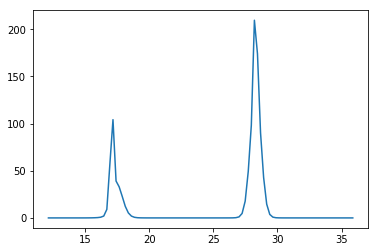

In [56]:
hist, bins = np.histogram(xyz[:, 0], weights=rho_grid, bins=100, range=(12, 36))
bins = (bins[:-1] + bins[1:])/2
plt.plot(bins, hist)

In [37]:
mol.coordinates

array([[8.69274 , 7.558904, 7.558904],
       [6.425069, 7.558904, 7.558904]])

In [58]:
zs

[8, 6]